# Building a Course Recommender Engine


`Description`

This module takes pre-processed dataset from NER engine comptuation nnotebook and extends on various use-cases for a complete user experience dashboard for Course Analytics. It also serves as the foundation for developing a recommendation engine. 

For the scope of the project, we have only consumed general knowledge and no fine-tuning or user-based filtering has been performed.

---
#### Contents:

1. Imports
2. Directory Setup

Training Phase
3. Raw Dataset
4. Semantic Similarity (IR Model)
5. Meta data generation: Course Keywords
6. Meta data generation: Course Summarization
7. Meta data generation: Course Difficulty

Testing Phase
8. Setup
8. Lookups
---

# 1. Imports

In [1]:
## Imports
'''Python Version 3.8.0'''

# Standard libs
import os
import sys
import json
import warnings
import yaml
import re
import io
from io import StringIO
import inspect
import shutil
import random
import ast
import string
import time
import pickle
import glob
import traceback
import multiprocessing
import requests
import logging
from ast import literal_eval
import math
import pytz
from itertools import chain
from string import Template
from datetime import datetime, timedelta
from dateutil import parser
import base64
from collections import defaultdict, Counter, OrderedDict
from contextlib import contextmanager
import unicodedata
from functools import reduce
import itertools
import tempfile
from typing import Any, Dict, List, Callable, Optional, Tuple, NamedTuple, Union
from functools import wraps

# Required pkgs
import numpy as np
from numpy import array, argmax
import pandas as pd
import ntpath
import tqdm

# General text correction - fit text for you (ftfy) and others
import ftfy
from fuzzywuzzy import fuzz
from spellchecker import SpellChecker

# scikit-learn
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# scipy
from scipy import spatial, sparse

# NLTK
import nltk
#nltk_model_data_path = "/someppath/"
#nltk.data.path.append(nltk_model_data_path)
from nltk import FreqDist, tokenize, sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords, PlaintextCorpusReader
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import *
from nltk.translate.bleu_score import sentence_bleu
print("NLTK loaded.")

# Spacy
import spacy
from spacy import displacy
from spacy.matcher import PhraseMatcher, Matcher
from spacy.util import minibatch, compounding
from spacy.training.example import Example
print("Spacy loaded.")

# Pytorch
import torch
from torch import optim, nn
import torch.nn.functional as Functional
from torch.utils.data import Dataset, DataLoader
import transformers
from transformers import AutoTokenizer
from transformers import AutoModelWithLMHead
from transformers import pipeline
from transformers import AutoModel
from sentence_transformers import SentenceTransformer, util
from bertopic import BERTopic
print("PyTorch loaded.")

# Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly import offline
%matplotlib inline

# Theme settings
pd.set_option("display.max_columns", 80)
sns.set_context('talk')
sns.set(rc={'figure.figsize':(15,10)})
sns.set_style("darkgrid")
warnings.filterwarnings('ignore')

NLTK loaded.


2023-04-03 14:32:19.839724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Spacy loaded.
PyTorch loaded.


# 2. Directory Setup

In [2]:
root_dir = os.path.abspath("../../")
data_dir = os.path.join(root_dir, "data")
ml_dir = os.path.join(root_dir, "mlEngine")
models_dir = os.path.join(ml_dir, "models")
sim_data_dir = os.path.join(os.path.join(ml_dir, "data"), "simLookup")

# NLP resources
nlp_resources_fp = os.path.join(models_dir, "resources")

# orignal file
courseData_fp = os.path.join(data_dir, "_UniversityServiceCourseInfo__202302190138.csv")
deptData_fp = os.path.join(data_dir, "courseNames_2023_02_12.csv")

# models
sbert_assym_model_fp = os.path.join(os.path.join(models_dir, "sbert"), "msmarco-distilbert-base-dot-prod-v3")
sbert_ssym_model_fp = os.path.join(os.path.join(models_dir, "sbert"), "all-distilroberta-v1")

# created files
course_info_data_fp = os.path.join(sim_data_dir, "course_info.csv")
assym_corpus_embeddings_fp = os.path.join(sim_data_dir, "simLookup_assym_corpus_embeddings.pkl")
ssym_corpus_embeddings_fp = os.path.join(sim_data_dir, "simLookup_ssym_corpus_embeddings.pkl")

# `---------------- Training Phase ---------------- `

# 3. Raw Dataset

In [17]:
# load original courseInfo data
org_df = pd.read_csv(courseData_fp)

# load deptarment data and create dept-id: dept mapper
dept_df = pd.read_csv(deptData_fp)
dept_mapper = dict()
for deptid, dept in zip(dept_df['department_id'], dept_df['department_name']):
    if deptid not in dept_mapper:
        dept_mapper[deptid] = dept
        
# corpus length
org_df['DescriptionLen'] = org_df['Description'].apply(lambda x: len(str(x)))

# instruction modes simplified
org_df = org_df.replace({"InstructionMode": {'In Person' : 'person', 
                                             'Hybrid Remote/Online': 'online', 
                                             'Remote': 'online', 
                                             'Online': 'online',
                                             'Hybrid InPrsn/OL-Remote': 'online',
                                             'Online Flex': 'online',
                                             'Independent Study': 'independent'}
                        })

# prerequisite courses
pattern = r'\b[A-Z]{4} \d{4}\b'
org_df['PreRequisites'] = org_df['RestrictedInfo'].apply(lambda x: list(set(re.findall(pattern, str(x)))) 
                                                         if re.findall(pattern, str(x)) else [])
org_df['PreRequisitesLen'] = org_df['PreRequisites'].apply(len)

In [18]:
# list of unique course-ids
course_ids = org_df['CourseID'].unique()

# course-metadata-mapper-dict
course_data = dict()
for courseid in tqdm.tqdm(course_ids):
    course_metadata = org_df[org_df['CourseID']==courseid].sort_values(by='DescriptionLen', ascending=False)
    course_data[courseid] = {
        'CourseName': course_metadata['CourseName'].values[0],
        'DepartmentId': course_metadata['DepartmentID'].values[0],
        'Desc': course_metadata['Description'].values[0],
        'Pre': course_metadata.sort_values(by='PreRequisitesLen', ascending=False)['PreRequisites'].values[0],
        'Mode': list(set(course_metadata['InstructionMode']))
    }



# final df
df = pd.DataFrame(course_data).T.reset_index().rename(columns={'index':'CourseId'})
df['Desc'] = df['Desc'].fillna("The course description is not available at this moment.")
df.insert(3, "DepartmentName", df.DepartmentId.apply(lambda x: dept_mapper[x] if x in dept_mapper.keys() else ""))

# save df
df.to_csv(course_info_data_fp, index=False)

print("Unique courses stored:", len(course_ids))
print("Indexed dataset stored: ", course_info_data_fp)

100%|██████████████████████████████████████| 3866/3866 [00:08<00:00, 466.56it/s]


Unique courses stored: 3866
Indexed dataset stored:  /Volumes/Local Drive/StudyBuff/GITHUB/StudyBuff/mlEngine/data/simLookup/course_info.csv


- Final dataset is ready

----

# 4. Semantic Similarity (IR Model)

Modelling: https://www.sbert.net/docs/pretrained-models/msmarco-v3.html

Acceleration for latency: https://www.philschmid.de/optimize-sentence-transformers

In [19]:
# CORPUS

df = pd.read_csv(course_info_data_fp)

corpus = (df['CourseId'].apply(str.lower) + ". " + \
          df['CourseName'].apply(str.lower) + ". " + \
          df['Desc'].apply(str.lower)).tolist()

print("Corpus loaded.")

Corpus loaded.


In [20]:
#################################################
# (1) model for assymetric search
# small sentence  - vs - all course desc
#################################################

# load assymetric model
assym_model = SentenceTransformer(sbert_assym_model_fp)

# encode corpus to get corpus embeddings
st=time.time()
assym_corpus_embeddings = assym_model.encode(corpus, convert_to_tensor=True)

# save assymetric corpus_embeddings to be loaded during runtime
with open(assym_corpus_embeddings_fp, "wb") as fp:
    pickle.dump(assym_corpus_embeddings, fp)

print("Total Time taken (mins): ", (time.time() - st)/60)

Total Time taken (mins):  7.909322082996368


In [21]:
#################################################
# (2) model for symetric search
# course desc  - vs -  all course desc
#################################################

# load assymetric model
ssym_model = SentenceTransformer(sbert_ssym_model_fp)

# encode corpus to get corpus embeddings
st=time.time()
ssym_corpus_embeddings = ssym_model.encode(corpus, convert_to_tensor=True)

# save symetric corpus_embeddings to be loaded during runtime
with open(ssym_corpus_embeddings_fp, "wb") as fp:
    pickle.dump(ssym_corpus_embeddings, fp)

print("Total Time taken (mins): ", (time.time() - st)/60)

Total Time taken (mins):  8.535967449347178


#### Next Steps:

accelerate prediction using latency reduction for pyTorch

---

# 5. Meta-data Generation: Keywords

For **clustered documents**, let's say you have a cluster with 20 documents, use **"Top2Vec", or "BERTopic"**

- Used for clustered documents
- used as Topic Modeller, LDA, lsa2vec
- returns topics across n documents (not applied on a single document!)

In [124]:
sample = df.Desc[0]
sample

'Introduces graduate level study of ethnic American and/or postcolonial writing in English, including relevant theoretical discourse.  Emphasizes a wide range of genres, forms, historical background, and secondary criticism.  Cultivates research skills necessary for advanced graduate study. Topics will vary.  May be repeated up to 6 total credit hours.'

In [128]:
# M1: Rake

# https://github.com/aneesha/RAKE
# pip install rake-nltk

In [129]:
from rake_nltk import Rake

r = Rake()
r.extract_keywords_from_text(sample)
r.get_ranked_phrases()

['including relevant theoretical discourse',
 'cultivates research skills necessary',
 '6 total credit hours',
 'introduces graduate level study',
 'advanced graduate study',
 'wide range',
 'secondary criticism',
 'postcolonial writing',
 'historical background',
 'ethnic american',
 'vary',
 'topics',
 'repeated',
 'may',
 'genres',
 'forms',
 'english',
 'emphasizes']

In [127]:
# M2: YAKE!

# https://github.com/LIAAD/yake
# pip install git+https://github.com/LIAAD/yake

In [146]:
import yake

language = "en"
max_ngram_size = 1
deduplication_threshold = 0.9
deduplication_algo = 'seqm'
windowSize = 1
numOfKeywords = 5

custom_kw_extractor = yake.KeywordExtractor(lan=language, n=max_ngram_size, dedupLim=deduplication_threshold, dedupFunc=deduplication_algo, windowsSize=windowSize, top=numOfKeywords, features=None)
keywords = custom_kw_extractor.extract_keywords(sample)

for kw in keywords:
    print(kw)

('English', 0.07901264396529444)
('American', 0.11254006070312061)
('Introduces', 0.1796102704524507)
('including', 0.1796102704524507)
('discourse', 0.1796102704524507)


In [ ]:
# M3: KeyBERT

# https://maartengr.github.io/KeyBERT/index.html
# pip install keybert

In [154]:
from keybert import KeyBERT

kw_model = KeyBERT()
keywords = kw_model.extract_keywords(sample, keyphrase_ngram_range=(1, 1))
phrases = kw_model.extract_keywords(sample, keyphrase_ngram_range=(1, 3))

In [155]:
keywords

[('graduate', 0.4898),
 ('writing', 0.4635),
 ('postcolonial', 0.4317),
 ('study', 0.3995),
 ('discourse', 0.344)]

In [156]:
phrases

[('postcolonial writing english', 0.5866),
 ('american postcolonial writing', 0.5803),
 ('postcolonial writing', 0.5634),
 ('graduate study', 0.5554),
 ('graduate level study', 0.5476)]

In [166]:
# Generate Keywords and Phrases:

from keybert import KeyBERT

def get_keywords_and_phrases(docs):
    kw_model = KeyBERT()
    keywords = kw_model.extract_keywords(docs, keyphrase_ngram_range=(1, 1), top_n=6)
    phrases = kw_model.extract_keywords(docs, keyphrase_ngram_range=(1, 3), top_n=8)
    return keywords, phrases

keywords, phrases = get_keywords_and_phrases(df['Desc'])

df['CourseKeywords'] = keywords
df['CourseKeywords'] = df['CourseKeywords'].apply(lambda x: [i[0] for i in x])
df['CourseKeyPhrases'] = phrases
df['CourseKeyPhrases'] = df['CourseKeyPhrases'].apply(lambda x: [i[0] for i in x])

# 6. Meta-data Generation: Summarization

In [188]:
from lexrank_algo import degree_centrality_scores

In [190]:
# M1: 

# model = AutoModelWithLMHead.from_pretrained(t5_base_location)
# tokenizer = AutoTokenizer.from_pretrained(t5_base_location)
# inputs = tokenizer.encode("summarize: " + sample, return_tensors="pt", max_length=512) 
# outputs = model.generate(inputs, max_length=250, min_length=30, length_penalty=2.0, num_beams=5, early_stopping=True, repetition_penalty=2.0) 
# print(tokenizer.decode(outputs[0]))

In [185]:
# M2:

sentences = nltk.sent_tokenize(sample)
embeddings = ssym_model.encode(sentences, convert_to_tensor=True)
#Compute the pair-wise cosine similarities
cos_scores = util.cos_sim(embeddings, embeddings).numpy()
#Compute the centrality for each sentence
centrality_scores = degree_centrality_scores(cos_scores, threshold=None)
most_central_sentence_indices = np.argsort(-centrality_scores)
print("Summary:")
" ".join([sentences[idx].strip() for idx in most_central_sentence_indices[0:3]])

Summary:


'Emphasizes a wide range of genres, forms, historical background, and secondary criticism. Topics will vary. Introduces graduate level study of ethnic American and/or postcolonial writing in English, including relevant theoretical discourse.'

In [191]:
# Generate Summary:

def get_summary(docs):
    summary_lst = []
    for doc in tqdm.tqdm(docs):
        sentences = nltk.sent_tokenize(doc)
        embeddings = ssym_model.encode(sentences, convert_to_tensor=True)
        cos_scores = util.cos_sim(embeddings, embeddings).numpy()
        centrality_scores = degree_centrality_scores(cos_scores, threshold=None)
        most_central_sentence_indices = np.argsort(-centrality_scores)
        summary_lst.append(" ".join([sentences[idx].strip() for idx in most_central_sentence_indices[0:3]]))
    return summary_lst

summaries = get_summary(df['Desc'])

df['CourseSummary'] = summaries

100%|███████████████████████████████████████| 3866/3866 [10:52<00:00,  5.93it/s]


# 7. Meta-data Generation: Course Difficulty

: Citation :

https://github.com/imperialite/lingfeat

@article{imperial2021knowledge,
  title={BERT Embeddings for Automatic Readability Assessment},
  author={Imperial, Joseph Marvin},
  journal={arXiv preprint arXiv:2106.07935},
  year={2021}
}

@inproceedings{reimers-2019-sentence-bert,
    title = "Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks",
    author = "Reimers, Nils and Gurevych, Iryna",
    booktitle = "Proceedings of the 2019 Conference on Empirical Methods in Natural Language Processing",
    month = "11",
    year = "2019",
    publisher = "Association for Computational Linguistics",
    url = "http://arxiv.org/abs/1908.10084",
}

In [54]:
from sklearn.preprocessing import MinMaxScaler
from lingfeat import extractor

In [55]:
diff_ratings = []
for doc in tqdm.tqdm(df.Desc):
    text = doc.strip().lower()
    LingFeat = extractor.pass_text(text)
    LingFeat.preprocess()
    TraF = LingFeat.TraF_()
    diff_ratings.append(round(np.mean(list(TraF.values())), 3))
normalizer = MinMaxScaler()
df['CourseDifficulty'] = normalizer.fit_transform(np.array(diff_ratings).reshape(-1,1))

<AxesSubplot: xlabel='CourseDifficulty', ylabel='Density'>

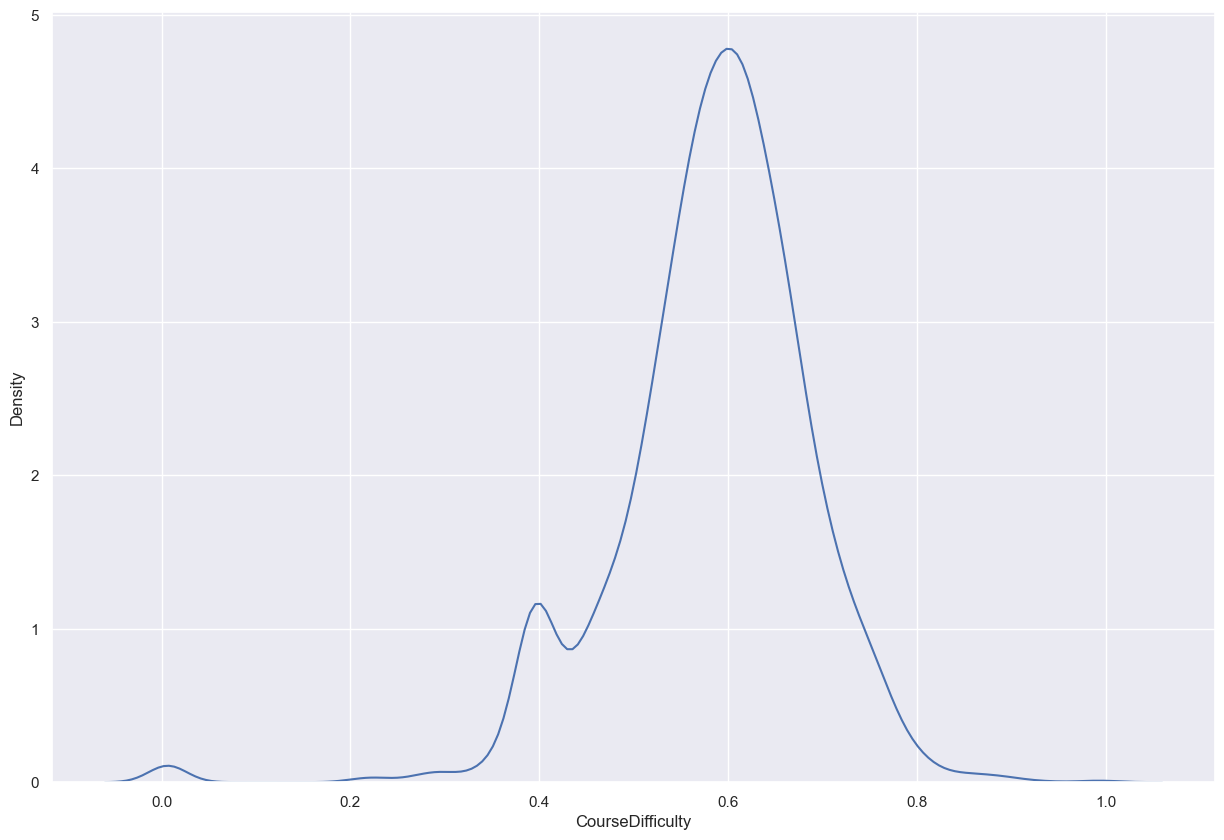

In [56]:
sns.kdeplot(df.CourseDifficulty)

In [57]:
df['CourseDifficultyBand'] = normalizer.fit_transform(df[['CourseDifficulty']])*100.0
df['CourseDifficultyBand'] = pd.cut(x=df['CourseDifficultyBand'], bins=[0.0, 10, 45, 70, 90, 100],
                                    labels=['Very Easy', 'Easy', 'Medium', 'Difficult', 'Very Difficult'])

In [58]:
df['CourseDifficultyBand'].value_counts()

Medium            3116
Difficult          376
Easy               349
Very Easy           19
Very Difficult       4
Name: CourseDifficultyBand, dtype: int64

In [59]:
# save df

df.to_csv(course_info_data_fp, index=False)

----
----

# `---------------- Testing Phase ---------------- `

# Setup

In [60]:
root_dir = os.path.abspath("../../")
data_dir = os.path.join(root_dir, "data")
ml_dir = os.path.join(root_dir, "mlEngine")
models_dir = os.path.join(ml_dir, "models")
sim_data_dir = os.path.join(os.path.join(ml_dir, "data"), "simLookup")
synonyms_fp = os.path.join(os.path.join(models_dir, "resources"), "synonyms.json")
course_info_data_fp = os.path.join(sim_data_dir, "course_info.csv")
deptData_fp = os.path.join(data_dir, "courseNames_2023_02_12.csv")
sbert_assym_model_fp = os.path.join(os.path.join(models_dir, "sbert"), "msmarco-distilbert-base-dot-prod-v3")
sbert_ssym_model_fp = os.path.join(os.path.join(models_dir, "sbert"), "all-distilroberta-v1")
sbert_assym_corpus_embeddings_fp = os.path.join(sim_data_dir, "simLookup_assym_corpus_embeddings.pkl")
sbert_ssym_corpus_embeddings_fp = os.path.join(sim_data_dir, "simLookup_ssym_corpus_embeddings.pkl")


# load synonyms
with open(synonyms_fp, "r") as f:
    synonyms = json.load(f)
        
# load trained models & embeds
spacy_model_fp = os.path.join(os.path.join(os.path.join(os.path.join(models_dir, "spacy"), "en_core_web_lg-3.5.0"), "en_core_web_lg"), "en_core_web_lg-3.5.0")
trained_ner_model_fp = os.path.join(os.path.join(models_dir, "spacy"), "trained_ner_model_v1.0")
nlp = spacy.load(spacy_model_fp)
course_nlp = spacy.load(trained_ner_model_fp)
assym_model = SentenceTransformer(sbert_assym_model_fp)
ssym_model = SentenceTransformer(sbert_ssym_model_fp)
with open(sbert_assym_corpus_embeddings_fp, "rb") as fp:
    assym_corpus_embeddings = pickle.load(fp)
with open(sbert_ssym_corpus_embeddings_fp, "rb") as fp:
    ssym_corpus_embeddings = pickle.load(fp)

In [61]:
# sample ner
doc = course_nlp("courses like big data architecture")
extracted_entities = []
for ent in doc.ents:
    extracted_entities.append((ent.text, ent.start_char, ent.end_char, ent.label_))
extracted_entities

[('big data architecture', 13, 34, 'COURSE_NAME')]

In [566]:
df = pd.read_csv(course_info_data_fp)

In [567]:
df

,CourseId,CourseName,DepartmentId,DepartmentName,Desc,Pre,Mode,CourseKeywords,CourseKeyPhrases,CourseSummary,CourseDifficulty,CourseDifficultyBand
0,ENGL 5169,Multicultural/Postcolonial Studies: Sound Stud...,ENGL,Department of English,Introduces graduate level study of ethnic Amer...,[],['person'],"['graduate', 'writing', 'postcolonial', 'study...","['postcolonial writing english', 'american pos...","Emphasizes a wide range of genres, forms, hist...",0.557381,Medium
1,CLAS 5129,Aegean Art and Archaeology,CLAS,Department of Classics,Detailed study of the cultures of prehistoric ...,[],['person'],"['crete', 'archaeology', 'greece', 'mediterran...","['prehistoric greece cycladic', 'cultures preh...",Emphasis is on palace states. Same as CLAS 412...,0.589075,Medium
2,ECEN 5341,Bioelectromagnetics,ECEN,"Department of Electrical, Computer, and Energy...",Effects of electric and magnetic fields on bio...,[],['person'],"['magnetic', 'biological', 'fields', 'electric...","['magnetic fields biological', 'fields biologi...",The complexity of biological systems is descri...,0.569167,Medium
3,ATLS 6910,Social Impact Practicum,ATLS,Department of Atlas Institute,This practicum allows Social Impact MS student...,"['ATLS 5210', 'ATLS 5240', 'ATLS 5230', 'ATLS ...",['person'],"['practicum', 'social', 'ms', 'assignments', '...","['social impact practicum', 'impact practicum ...",This practicum allows Social Impact MS student...,0.646494,Medium
4,BCHM 5491,Modern Biophysical Methods,BCHM,Department of Biochemistry,Covers the basic theory of biophysical methods...,[],['person'],"['biophysical', 'biochemistry', 'spectroscopy'...","['biophysical methods widely', 'biophysical me...",Covers the basic theory of biophysical methods...,0.726881,Difficult
...,...,...,...,...,...,...,...,...,...,...,...,...
3861,LAWS 7418,Legal Imagination,LAWS,Law School,Advanced course in reading and writing for law...,[],['person'],"['lawyer', 'literary', 'ambitions', 'writer', ...","['writing law students', 'reading writing law'...",Advanced course in reading and writing for law...,0.524932,Medium
3862,PHYS 7240,Advanced Statistical Mechanics,PHYS,Physics Department,Introduces current research topics in statisti...,[],['person'],"['topics', 'phys', 'statistical', 'prerequisit...","['statistical mechanics topics', 'topics stati...",Topics vary from year to year and may include ...,0.551828,Medium
3863,PHYS 7430,Soften Condensed Matter Physics,PHYS,Physics Department,"Introduces the science of liquid crystals, pol...",[],['person'],"['biopolymers', 'polymers', 'colloids', 'copol...","['science liquid crystals', 'liquid crystals p...","Introduces the science of liquid crystals, pol...",0.748678,Difficult
3864,PHIL 2160,Ethics and Information Technology,PHIL,Philosophy Department,Examines contemporary ethical issues concernin...,[],['online'],"['hacking', 'ethical', 'technologies', 'misuse...","['contemporary ethical issues', 'topics includ...",Examines contemporary ethical issues concernin...,0.786076,Difficult


# Lookups

In [594]:
class RECSYSTEM:

    def __init__(self, config, synonyms, assym_model, ssym_model, assym_corpus_embeddings, ssym_corpus_embeddings, df_allcoursesdata):
        self.config = config
        self.synonyms = synonyms
        self.synonyms_mapper = {v: k for k, v_list in synonyms.items() for v in v_list}
        self.assym_model = assym_model
        self.ssym_model = ssym_model
        self.assym_corpus_embeddings = assym_corpus_embeddings
        self.ssym_corpus_embeddings = ssym_corpus_embeddings
        self.do_preprocess = config.get("rec_do_preprocess_bool")
        self.max_assymeteric_len = config.get("max_assymeteric_len_num")
        self.return_k_similar = config.get("return_k_similar_num")
        self.type_of_query = []   # tells if user asked for online, pre-requisities, etc.

        # get saved All courses meta-data information for IR
        # ** plugin required **
        self.allcoursesdata = df_allcoursesdata

        #logger.info("RECSYSTEM initialized")
        return

    def get_model(self, query):
        """
            Chooses a semantic search model based on query length
            :param:    query: str - user input query
            :return:   model: object - use loaded recommender model object
                       corpus_embeddings: tensor - use loaded vectorized embeddings of all courses in tensor fmt
        """
        if len(query) <= self.max_assymeteric_len:
            model = self.assym_model
            corpus_embeddings = self.assym_corpus_embeddings
        else:
            model = self.ssym_model
            corpus_embeddings = self.ssym_corpus_embeddings
        return model, corpus_embeddings

    def preprocess_query(self, query):
        """
            Uses sister pre-process module and executes pre-processing for a given str query
            :param:    query: str - user input query
            :return:   query: str - preprocessed query
        """
        query = str(query).strip()
        query = ftfy.fix_text(query)
        # Find if there are any "online" or "prerequisites" synonymous words to re-route queries to
        # platform specific responses (dialogue management)
        found_synonyms = []
        for finders in self.synonyms.keys():
            isFind = re.findall(r"(?=(" + '|'.join(self.synonyms[finders]) + r"))", query)
            if len(isFind) > 0:
                found_synonyms.append(self.synonyms_mapper[isFind[0]])
        query = re.sub(r"([\s\n\t\r]+)", " ", query).strip()
        query = re.sub(r"[\$|\#\@\*\%]+\d+[\$|\#\@\*\%]+", " ", query)
        query = re.sub(r"[\/,\@,\#,\\,\{,\},\(,\),\[,\],\$,\%,\^,\&,\*,\<,\>]", " ", query)
        query = re.sub(r"[\,,\;,\:,\-]", " ", query)
        query = re.sub(r"[\!,\?,\.]", " ", query)
        query = str(query).strip().lower()
        return query, sorted(set(found_synonyms))

    def get_top_k(self, query, display=False):
        """
            Loads desired model and all-course-embeddings and returns ranked recommendations (IR).
            :param:    query: str - user input query (preprocessed or not)
            :return:   ranked_df:
        """
        # optional pre-processing unit
        found_synonyms = []
        if self.do_preprocess and self.do_preprocess is True:
            query, found_synonyms = self.preprocess_query(query)
        else:
            query = str(query).strip().lower()

        # get loaded configurations
        data = self.allcoursesdata
        model, corpus_embeddings = self.get_model(query)

        # encode sentence to get sentence embeddings
        sentence_embedding = model.encode(query, convert_to_tensor=True)

        # 'top_k' similar results to return
        top_k = self.return_k_similar

        # compute cosine similarity scores
        cos_scores = util.pytorch_cos_sim(sentence_embedding, corpus_embeddings)[0]

        # Sort the results in decreasing order and get the first top_k
        top_results = np.argpartition(-cos_scores, range(top_k))[0:top_k].numpy()
        
        # IR
        ranked_df = data[data.index.isin(top_results)]
        ranked_df.loc[top_results, "ConfidenceScore"] = [cos_scores[idx]*100.0 for idx in top_results]
        ranked_df = ranked_df.sort_values(by=['ConfidenceScore'], ascending=False)

        # Dialogue Management
        # if there are any "online" or "prerequisites" synonymous words in user query, re-route responses to match
        # specific answers only.
        if len(found_synonyms) > 0:
            if "online_list" in found_synonyms:
                ranked_df = ranked_df[(ranked_df.Mode == "['person', 'online']") |
                                      (ranked_df.Mode == "['online']") |
                                      (ranked_df.Mode == "['independent', 'person', 'online']")]
                self.type_of_query.append("Online")
            if "prereq_list" in found_synonyms:
                ranked_df = ranked_df[ranked_df.Pre != "[]"]
                self.type_of_query.append("Prerequisites")
        else:
            self.type_of_query.append("Person")
        if display:
            for idx in top_results[0:top_k]:
                crn = ranked_df.loc[idx, "CourseName"]
                #print(crn, "\t(Score: %.4f)" % (cos_scores[idx]))
                logger.info("Recommended:\nCourse: {};\t\tScore: {}".format(crn, cos_scores[idx]))
        return ranked_df.reset_index(drop=True)

    def run(self, query, display=False):
        """
            Main Execute Recommender System using Information Retrieval (IR)
        """
        # if multiple queries
        if isinstance(query, list) or isinstance(query, tuple) or isinstance(query, pd.Series):
            n = int(self.return_k_similar)
            k = len(query)
            dists = np.arange(n+k-1, n-1, -1) // k
            ranked_similar_courses_metadata = pd.DataFrame()
            for i, q in enumerate(query):
                ranked_similar_courses_metadata = ranked_similar_courses_metadata.append(self.get_top_k(q, display=False)[:dists[i]])
        elif isinstance(query, str):
            if query is None or len(query.strip()) < 3 or query == "":
                return []
            ranked_similar_courses_metadata = self.get_top_k(query, display=display)
        else:
            raise Exception("Invalid query type! Accepted str, list, series.")
        # final
        output = {
            "top_similar_count": self.return_k_similar,
            "platform": self.type_of_query,
            "top_similar_courses": ranked_similar_courses_metadata.reset_index(drop=True).to_json(orient='records')
        }
        #return output
        return ranked_similar_courses_metadata
        
#EOF

In [637]:
input_q = ["Big Data", "machine learning"]

In [638]:
 config = {
     "rec_do_preprocess_bool": True,
     "max_assymeteric_len_num": 120,
     "return_k_similar_num": 10
 }

In [639]:
rec = RECSYSTEM(config,
                synonyms, 
                assym_model, 
                ssym_model, 
                assym_corpus_embeddings, 
                ssym_corpus_embeddings, 
                df)

In [640]:
out = rec.run(input_q)
out

,CourseId,CourseName,DepartmentId,DepartmentName,Desc,Pre,Mode,CourseKeywords,CourseKeyPhrases,CourseSummary,CourseDifficulty,CourseDifficultyBand,ConfidenceScore
0,ATLS 5214,Big Data Architecture,ATLS,Department of Atlas Institute,Provides students with a comprehensive survey ...,[],['person'],"['atls', 'technologies', 'projects', 'students...","['project atls', 'project atls 4214', 'group p...",Provides students with a comprehensive survey ...,0.554850,Medium,57.375778
1,CSCI 6502,"Big Data Analytics: Systems, Algorithms, and A...",CSCI,Department of Computer Science,This course studies state-of-the-art practice ...,[],"['person', 'online']","['mapreduce', 'nosql', 'analytics', 'iot', 'co...","['big data', 'big data analytics', 'big data s...","Specifically, this course covers big data syst...",0.730961,Difficult,56.675888
2,ATLS 4214,Big Data Architecture,ATLS,Department of Atlas Institute,Provides students with a comprehensive survey ...,"['CSCI 2270', 'CSCI 2275']",['person'],"['atls', 'technologies', 'projects', 'students...","['project atls', 'project atls 5214', 'group p...",Provides students with a comprehensive survey ...,0.554850,Medium,56.620216
3,GEOG 3023,Statistics and Geographic Data,GEOG,Department of Geography,Introduces computational and statistical tools...,[],"['person', 'online']","['geographic', 'statistical', 'statistics', 's...","['spatial data', 'spatial data requires', 'sol...",Introduces computational and statistical tools...,0.607736,Medium,46.852764
4,ACCT 5120,Business Analytics,ACCT,Department of Accounting,Teaches cutting-edge tools and approaches to t...,[],['person'],"['analytics', 'data', 'application', 'monitori...","['including big data', 'big data', 'big data e...",Teaches cutting-edge tools and approaches to t...,0.660056,Medium,46.545963
0,CSCI 5622,Machine Learning,CSCI,Department of Computer Science,Trains students to build computer systems that...,"['MATH 2130', 'APPM 3570', 'APPM 3310', 'MATH ...","['person', 'online']","['learning', 'algorithms', 'supervised', 'mode...","['computer systems learn', 'decision trees', '...",Emphasizes practical and theoretical understan...,0.643812,Medium,69.705322
1,CSCI 4622,Machine Learning,CSCI,Department of Computer Science,"Introduces students to tools, methods, and the...","['MATH 3510', 'MCEN 3047', 'STAT 3100', 'ECON ...",['person'],"['supervised', 'models', 'algorithms', 'learni...","['machine learning technique', 'machine learni...",Focuses on supervised machine learning techniq...,0.640035,Medium,67.909607
2,INFO 5604,Applied Machine Learning,INFO,Information Science Department,Introduces algorithms and tools for building i...,[],['person'],"['algorithms', 'classification', 'clustering',...","['building intelligent computational', 'intell...",Students will learn the theoretical underpinni...,0.638486,Medium,67.661682
3,CSPB 4622,Machine Learning,CSPB,Department of Cognitive Science and Psychology...,"Introduces students to tools, methods, and the...",[],['online'],"['supervised', 'algorithms', 'models', 'learni...","['machine learning technique', 'machine learni...",Focuses on supervised machine learning techniq...,0.640035,Medium,67.446724
4,INFO 4604,Applied Machine Learning,INFO,Information Science Department,Introduces algorithms and tools for building i...,"['CSCI 2270', 'INFO 2301', 'INFO 2201']",['person'],"['algorithms', 'classification', 'clustering',...","['building intelligent computational', 'intell...",Students will learn the theoretical underpinni...,0.638486,Medium,67.182808


---